In [1]:
import yahoo_fin.stock_info as si
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ma(data, lookback, close, position): 
    
    data = add_column(data, 1)
    
    for i in range(len(data)):
           
            try:
                
                data[i, position] = (data[i - lookback + 1:i + 1, close].mean())
            
            except IndexError:
                
                pass
            
    data = delete_row(data, lookback)
    
    return data

def add_column(data, times):
    
    for i in range(1, times + 1):
    
        new = np.zeros((len(data), 1), dtype = float)
        
        data = np.append(data, new, axis = 1)

    return data

def delete_column(data, index, times):
    
    for i in range(1, times + 1):
    
        data = np.delete(data, index, axis = 1)

    return data

def delete_row(data, number):
    
    data = data[number:, ]
    
    return data

def ohlc_plot_bars(data, window):
     
    sample = data[-window:, ]
    
    for i in range(len(sample)):
        
        plt.vlines(x = i, ymin = sample[i, 2], ymax = sample[i, 1], color = 'black', linewidth = 1)  
        
        if sample[i, 3] > sample[i, 0]:
            
            plt.vlines(x = i, ymin = sample[i, 0], ymax = sample[i, 3], color = 'black', linewidth = 1)  

        if sample[i, 3] < sample[i, 0]:
            
            plt.vlines(x = i, ymin = sample[i, 3], ymax = sample[i, 0], color = 'black', linewidth = 1)  
            
        if sample[i, 3] == sample[i, 0]:
            
            plt.vlines(x = i, ymin = sample[i, 3], ymax = sample[i, 0] + 0.00005, color = 'black', linewidth = 1.00)  
            
    plt.grid()
    
def signal_chart(data, position, buy_column, sell_column, window = 500):   
 
    sample = data[-window:, ]

    fig, ax = plt.subplots(figsize = (10, 5))
    
    ohlc_plot_bars(data, window)    

    for i in range(len(sample)):
        
        if sample[i, buy_column] == 1:
            
            x = i
            y = sample[i, position]
        
            ax.annotate(' ', xy = (x, y), 
                        arrowprops = dict(width = 9, headlength = 17, headwidth = 17, facecolor = 'green', color = 'green'))
        
        elif sample[i, sell_column] == -1:
            
            x = i
            y = sample[i, position]
        
            ax.annotate(' ', xy = (x, y), 
                        arrowprops = dict(width = 9, headlength = -17, headwidth = -17, facecolor = 'red', color = 'red'))  


In [3]:
# Importing historical data
data = si.get_data("^GSPC")

In [4]:
# Converting data frame to array and keeping essential OHLC data
data = data.iloc[:, 0:4].values

In [5]:
# Calculating the Moving averages
data = ma(data, 8, 3, 4)
data = ma(data, 20, 3, 5)

/var/folders/_v/wntxb4nx76l_5s1m0z5nv4tm0000gn/T/ipykernel_71868/3536654982.py:9: RuntimeWarning: Mean of empty slice.
  data[i, position] = (data[i - lookback + 1:i + 1, close].mean())
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Creating the trading signals (Buying at the next open of the confirmation of the cross)
def signal(data, eight_period_ma_column, twenty_period_ma_column, buy_column, sell_column):

    data = add_column(data, 10)
        
    for i in range(len(data)):
        
       try:
           
           # Bullish setup
           if data[i, eight_period_ma_column] > data[i, twenty_period_ma_column] and \
              data[i - 1, eight_period_ma_column] < data[i - 1 , twenty_period_ma_column]:
                  
                    data[i + 1, buy_column] = 1
                    
           # Bearish setup
           elif data[i, eight_period_ma_column] < data[i, twenty_period_ma_column] and \
                data[i - 1, eight_period_ma_column] > data[i - 1 , twenty_period_ma_column]:
                  
                    data[i + 1, sell_column] = -1
                    
       except IndexError:
            
            pass
        
    return data

In [7]:
data = signal(data, 4, 5, 6, 7)

/var/folders/_v/wntxb4nx76l_5s1m0z5nv4tm0000gn/T/ipykernel_71868/3536654982.py:80: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.annotate(' ', xy = (x, y),
/var/folders/_v/wntxb4nx76l_5s1m0z5nv4tm0000gn/T/ipykernel_71868/3536654982.py:88: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.annotate(' ', xy = (x, y),


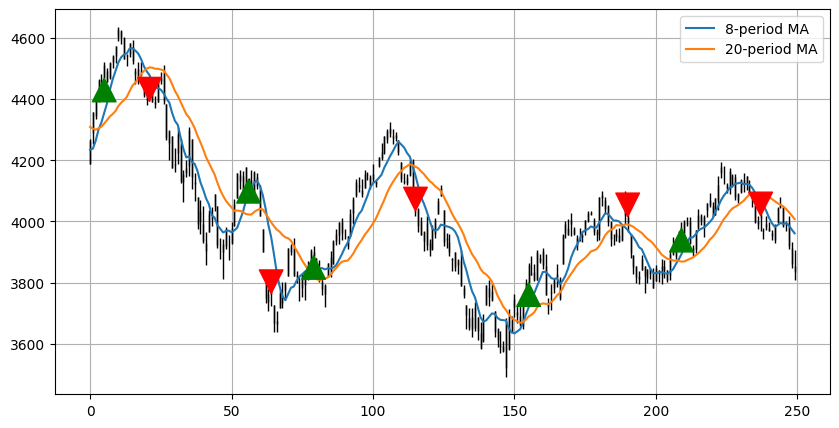

In [8]:
# Signal chart for illustration
signal_chart(data, 0, 6, 7, window = 250)
plt.plot(data[-250:, 4], label = '8-period MA')
plt.plot(data[-250:, 5], label = '20-period MA')
plt.legend()
plt.show()

In [9]:
# Calculating the slope of the 8-period MA (period = 8)
def slope(data, ma_column, period, position):
    
    for i in range(len(data)):
        
        data[i, position] = (data[i, ma_column] - data[i - period, ma_column]) / period
        
    return data

In [10]:
data = slope(data, 4, 8, 8)

In [11]:
# Performance evaluation given the exit condition (slope of 8-period MA ~ zero)
def performance(data, 
                 open_price, 
                 buy_column, 
                 sell_column,
                 slope_column,
                 long_result_col, 
                 short_result_col, 
                 total_result_col):
    
    # Variable holding period
    for i in range(len(data)):
        
        try:
            
            if data[i, buy_column] == 1:
                
                for a in range(i + 1, i + 10000):
                    
                    if data[a, buy_column] == 1 or data[a, sell_column] == -1:
                        
                        data[a, long_result_col] = data[a, 3] - data[i, open_price]
                        break
                    
                    elif data[a, slope_column] < 0 and data[a - 1, slope_column] > 0:
                        
                        data[a, long_result_col] = data[a, 3] - data[i, open_price]
                        break
                    
                    else:
                        
                        continue                
                    
            else:
                
                continue
            
        except IndexError:
            
            pass
                    
    for i in range(len(data)):
        
        try:
            
            if data[i, sell_column] == -1:
                
                for a in range(i + 1, i + 10000):
                                        
                    if data[a, buy_column] == 1 or data[a, sell_column] == -1:
                        
                        data[a, short_result_col] = data[i, open_price] - data[a, 3]
                        break   
                    
                    elif data[a, slope_column] > 0 and data[a - 1, slope_column] < 0:
                        
                        data[a, long_result_col] = data[i, open_price] - data[a, 3]
                        break
                     
                    else:
                        
                        continue
                    
            else:
                continue
            
        except IndexError:
            
            pass   
        

In [15]:
# Aggregating the long & short results into one column
data[:, total_result_col] = data[:, long_result_col] + data[:, short_result_col]  
    
# Profit factor    
total_net_profits = data[data[:, total_result_col] > 0, total_result_col]
total_net_losses  = data[data[:, total_result_col] < 0, total_result_col] 
total_net_losses  = abs(total_net_losses)
profit_factor     = round(np.sum(total_net_profits) / np.sum(total_net_losses), 2)

# Hit ratio    
hit_ratio         = len(total_net_profits) / (len(total_net_losses) + len(total_net_profits))
hit_ratio         = hit_ratio * 100
    
# Risk reward ratio
average_gain            = total_net_profits.mean()
average_loss            = total_net_losses.mean()
realized_risk_reward    = average_gain / average_loss

# Number of trades
trades = len(total_net_losses) + len(total_net_profits)
        
print('Hit Ratio         = ', hit_ratio)
print('Profit factor     = ', profit_factor) 
print('Realized RR       = ', round(realized_risk_reward, 3))
print('Number of Trades  = ', trades)    
   
return data


NameError: name 'long_result_col' is not defined

In [16]:
data = performance(data, 
                 0, 
                 6, 
                 7,
                 8,
                 9, 
                 10, 
                 11)

# Equity curve
for i in range(len(data)):
    
    data[i, 12] = data[i - 1, 12] + data[i , 11]

# plt.plot(data[:, 12])

TypeError: object of type 'NoneType' has no len()